In [1]:
import re
import sys
import os
import yaml
import pandas as pd
import mlflow
import subprocess
from mlflow import MlflowClient

from pathlib import Path
from pydantic import BaseModel
from typing import Optional, List
from collections import namedtuple

from visualize.plots import (
    plot_f1_score,
    plot_f1_score_line_plot,
)

from visualize.mlflow_utils import get_last_n_runs, runs_to_df

from src.util.custom_logging import Pickler
from src.util.constants import Directory

In [2]:
pd.set_option("display.precision", 4)

In [3]:
class Dataset(BaseModel):

    id: str
    name: str
    runs: int
    query: str

In [4]:
def get_data(name: str, query: str, n_runs: int) -> pd.DataFrame:

    result = subprocess.run([f"{sys.executable}", "visualize\mlflow_utils.py", "--filename", name, "--query", query, "--n_runs", str(n_runs)], stderr=subprocess.PIPE, text=True)

    print(query)
    
    # Check the status
    if result.returncode == 0:
        print("Config creation successful.")
    else:
        print(f"Subprocess failed with return code {result.returncode}.")
        print("Error output:")
        print(result.stderr)
        raise ValueError("Subprocess exited unexpectedly")
    
    vis_dir = Directory.ROOT / 'notebooks/visualize'
    datasets_filename = vis_dir / f"{name}.yaml"

    with open(datasets_filename, "r") as file:
        datasets = yaml.safe_load(file)

    # reformatting datasets for easier access
    datasets = [Dataset(name=key, **values) for key, values in datasets.items()]
    
    # result
    result = []

    for dataset in datasets:

        runs = get_last_n_runs(
            experiment_id=dataset.id, n=dataset.runs, query=dataset.query
        )

        if len(runs) == 0:
            raise ValueError("No runs found")
        
        data = runs_to_df(runs)
        
        result.append(data)


    result = pd.concat(result)

    result.reset_index(drop=True, inplace=True)
    
    return result

def get_artifact_paths(directory: str):
    
    artifacts = list(Path(directory[6:]).glob('*'))
    
    return artifacts

def get_artifact_by_name(name: str, artifacts: List):
    
    result = [el for el in artifacts if name in str(el)]
    
    assert len(result) == 1
    
    return result[0]

## Feature Selection Analysis

In [5]:
paths = []

for case in ['synthetic', 'malware', 'churn']:

    data = get_data(name=case, n_runs=1, query=f"feat_selection__{case}%")
    directory = data["artifact_uri"].head(1).values[0]
    artifacts = get_artifact_paths(directory=directory)
    path_to_artifact = get_artifact_by_name(name='conf_target', artifacts=artifacts)

    paths.append((case, path_to_artifact))
    #rule_conf_analysis(path_to_artifact=path_to_artifact)

feat_selection__synthetic%
Config creation successful.
feat_selection__malware%
Config creation successful.
feat_selection__churn%
Config creation successful.


In [6]:
from scipy.stats import pearsonr

dfs = []

for case, path in paths:

    print(case)

    data = Pickler.load(path)

    thresholds = {
        'synthetic': 0.025,
        'malware': 0.0005,
        'churn': 0.025
    }

    mask = data['mean_ranking'] > -1 # thresholds[case]

    print(data[mask].shape)
    
    print(data[['deviation_from_mean_target', 'mean_confidence']][mask].corr())
    print(pearsonr(data['deviation_from_mean_target'][mask], data['mean_confidence'][mask], alternative='greater'))

    dfs.append((case, data[mask]))

synthetic
(54, 40)
                            deviation_from_mean_target  mean_confidence
deviation_from_mean_target                      1.0000           0.8937
mean_confidence                                 0.8937           1.0000
PearsonRResult(statistic=0.8937143040957487, pvalue=4.854434397309382e-20)
malware
(444, 40)
                            deviation_from_mean_target  mean_confidence
deviation_from_mean_target                      1.0000           0.6886
mean_confidence                                 0.6886           1.0000
PearsonRResult(statistic=0.688640028861275, pvalue=5.4406637346472055e-64)
churn
(41, 40)
                            deviation_from_mean_target  mean_confidence
deviation_from_mean_target                      1.0000           0.6032
mean_confidence                                 0.6032           1.0000
PearsonRResult(statistic=0.6031983414814396, pvalue=1.4949608572657927e-05)


In [7]:
tmp = dfs[1][1]

cols = ['index', 'Confidence Delta']
cols += tmp.filter(like='conf').columns.to_list()

tmp.sort_values(by='Confidence Delta')[cols]


KeyboardInterrupt



In [ ]:
import yaml
from src.fetch_data.malware import MalwareDataloader
yaml_path = r"C:\Users\di872\Desktop\cts\config\fetch_data\malware.yaml"

with open(yaml_path, 'r') as file:
    config = yaml.safe_load(file)['params']
    config['resampling_fraction'] = 1

dataloader = MalwareDataloader(**config)

tmp = dataloader.execute()['data']



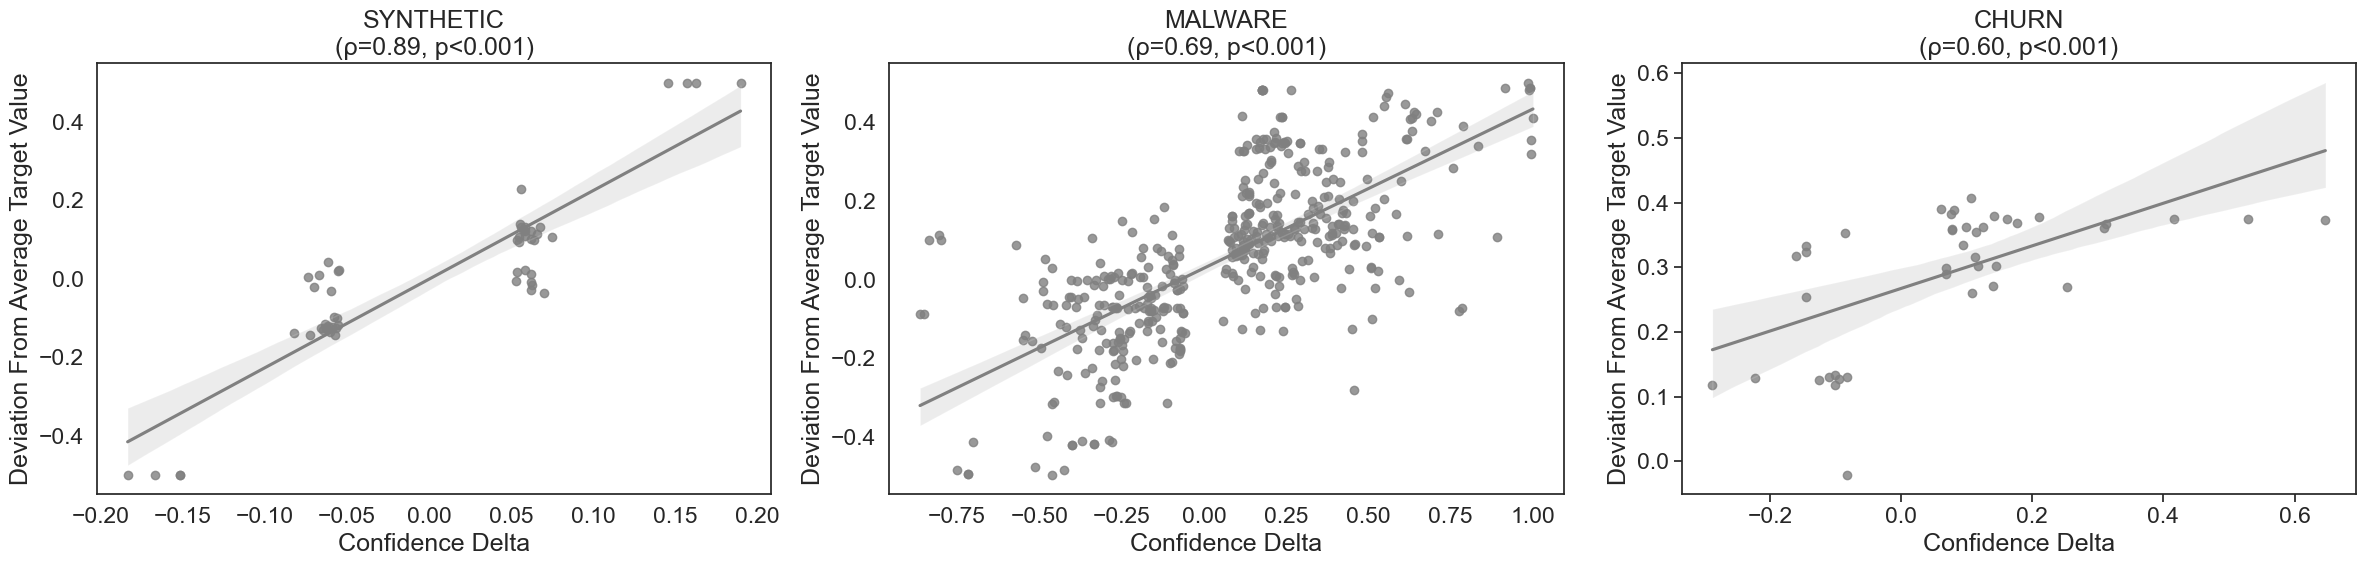

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('white')

f, axes = plt.subplots(1, len(dfs), sharey=False, figsize=(24,6))

for idx, (case, df) in enumerate(dfs):

    df.rename({'deviation_from_mean_target': 'Deviation From Average Target Value', 'mean_confidence': 'Confidence Delta', 'mean_ranking': 'Ranking'}, axis=1, inplace=True)
    #sns.scatterplot(data=data[mask], x='Confidence Delta', y='Deviation From Average Target', color='grey', linewidth=1, edgecolor='grey', markers='x')

    titles = {
        'synthetic': "SYNTHETIC\n(ρ=0.89, p<0.001)",
        'malware': "MALWARE\n(ρ=0.69, p<0.001)",
        'churn': "CHURN\n(ρ=0.60, p<0.001)"
    }
    
    axes[idx].title.set_text(titles[case])
    sns.regplot(data=df, x='Confidence Delta', y='Deviation From Average Target Value', color='grey', ax=axes[idx])
    
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
plt.tight_layout()
plt.savefig('scatter_feat_selection.pdf', dpi=300)
plt.savefig('scatter_feat_selection.png', dpi=300)
plt.show()

In [ ]:
def rule_conf_analysis(path_to_artifact):
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    from scipy.stats import pearsonr
    
    sns.set_style('white')
        
    data = Pickler.load(path_to_artifact)
                        
    mask = data['mean_ranking'] > 0.001 # 0.001
    #mask = data['mean_support'] > 0.015
    
    print(data[mask].shape)
    
    print(data[['deviation_from_mean_target', 'mean_confidence']][mask].corr())
    print(pearsonr(data['deviation_from_mean_target'][mask], data['mean_confidence'][mask], alternative='greater'))
    
    #print(data[mask][['index', 'avg_target', 'mean_confidence', 'mean_support', 'mean_ranking']].sort_values(by='avg_target'))
    #data[mask].plot(kind='scatter', x='mean_confidence', y='avg_target')
    
    data.rename({'deviation_from_mean_target': 'Deviation From Average Target', 'mean_confidence': 'Confidence Delta', 'mean_ranking': 'Ranking'}, axis=1, inplace=True)
    #sns.scatterplot(data=data[mask], x='Confidence Delta', y='Deviation From Average Target', color='grey', linewidth=1, edgecolor='grey', markers='x')
    sns.regplot(data=data[mask], x='Confidence Delta', y='Deviation From Average Target', color='grey')
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    plt.tight_layout()
    plt.savefig('scatter_feat_selection.pdf', dpi=300)
    plt.show()
    
    plt.figure()
    sns.displot(data=data[mask], x='Ranking', binwidth=0.001, color='grey')
    plt.ylabel('Count of Sequences')
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    plt.tight_layout()
    plt.savefig('hist_ranking_feat_selection.pdf', dpi=300)
    plt.show()


data = get_data(name='malware', n_runs=1, query="%synthetic__feat_selection__cts__model__xgb__features__null%")
directory = data["artifact_uri"].head(1).values[0]
artifacts = get_artifact_paths(directory=directory)
path_to_artifact = get_artifact_by_name(name='conf_target', artifacts=artifacts)
rule_conf_analysis(path_to_artifact=path_to_artifact)

## Classification Analysis

In [17]:
data = get_data(name='sim', query='oh%', n_runs=9999)
data

oh%
Config creation successful.


,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,constants.event_column.placeholder,constants.event_column.value,constants.id_column.placeholder,constants.id_column.value,constants.target_column.placeholder,...,fetch_data.params.configuration.h-i.class,fetch_data.params.configuration.h-i.selection,fetch_data.params.configuration.i-j.class,fetch_data.params.configuration.i-j.selection,fetch_data.params.event_column,fetch_data.params.id_column,fetch_data.params.n_samples,fetch_data.params.separator,fetch_data.params.sequence_elements,fetch_data.params.time_column
0,0.8322,0.8476,0.7765,0.9331,0.8322,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.8314,0.8475,0.7735,0.9372,0.8314,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.8197,0.8369,0.7638,0.9255,0.8197,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.8305,0.8463,0.7743,0.9331,0.8305,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.8192,0.8373,0.7611,0.9305,0.8192,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,0.8952,0.9006,0.8562,0.9500,0.9781,event_column,event_column,id_column,id_column,target,...,0,0.1,0,0.1,event_column,id_column,20000,-,"a,b,c,d,e,f,g,h,i,j,k,l,m,n,o",timestamp
2008,0.8985,0.8918,0.9544,0.8369,0.9812,event_column,event_column,id_column,id_column,target,...,0,0.1,0,0.1,event_column,id_column,20000,-,"a,b,c,d,e,f,g,h,i,j,k,l,m,n,o",timestamp
2009,0.8985,0.8918,0.9544,0.8369,0.9812,event_column,event_column,id_column,id_column,target,...,0,0.1,0,0.1,event_column,id_column,20000,-,"a,b,c,d,e,f,g,h,i,j,k,l,m,n,o",timestamp
2010,0.8962,0.8902,0.9449,0.8414,0.9797,event_column,event_column,id_column,id_column,target,...,0,0.1,0,0.1,event_column,id_column,20000,-,"a,b,c,d,e,f,g,h,i,j,k,l,m,n,o",timestamp


In [6]:
data.to_parquet('spm_results.parquet')

In [16]:
pd.read_parquet('spm_results.parquet')

,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,constants.event_column.placeholder,constants.event_column.value,constants.id_column.placeholder,constants.id_column.value,constants.target_column.placeholder,...,fetch_data.params.configuration.h-i.class,fetch_data.params.configuration.h-i.selection,fetch_data.params.configuration.i-j.class,fetch_data.params.configuration.i-j.selection,fetch_data.params.event_column,fetch_data.params.id_column,fetch_data.params.n_samples,fetch_data.params.separator,fetch_data.params.sequence_elements,fetch_data.params.time_column
0,0.8201,0.8337,0.7750,0.9021,0.8201,product_action,product_action,session_id,session_id,label,...,None,None,None,None,None,None,None,None,None,None
1,0.8192,0.8340,0.7711,0.9079,0.8192,product_action,product_action,session_id,session_id,label,...,None,None,None,None,None,None,None,None,None,None
2,0.8088,0.8242,0.7628,0.8962,0.8088,product_action,product_action,session_id,session_id,label,...,None,None,None,None,None,None,None,None,None,None
3,0.8218,0.8358,0.7748,0.9071,0.8218,product_action,product_action,session_id,session_id,label,...,None,None,None,None,None,None,None,None,None,None
4,0.7929,0.8043,0.7624,0.8510,0.7929,product_action,product_action,session_id,session_id,label,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,0.8998,0.8915,0.9706,0.8244,0.9806,event_column,event_column,id_column,id_column,target,...,0,0.1,0,0.1,event_column,id_column,20000,-,"a,b,c,d,e,f,g,h,i,j,k,l,m,n,o",timestamp
1976,0.8952,0.9006,0.8562,0.9500,0.9781,event_column,event_column,id_column,id_column,target,...,0,0.1,0,0.1,event_column,id_column,20000,-,"a,b,c,d,e,f,g,h,i,j,k,l,m,n,o",timestamp
1977,0.8985,0.8918,0.9544,0.8369,0.9812,event_column,event_column,id_column,id_column,target,...,0,0.1,0,0.1,event_column,id_column,20000,-,"a,b,c,d,e,f,g,h,i,j,k,l,m,n,o",timestamp
1978,0.8978,0.9025,0.8620,0.9470,0.9791,event_column,event_column,id_column,id_column,target,...,0,0.1,0,0.1,event_column,id_column,20000,-,"a,b,c,d,e,f,g,h,i,j,k,l,m,n,o",timestamp


In [9]:
data[feat_col].unique()

NameError: name 'feat_col' is not defined

In [17]:
model_col = 'model.params.model'
n_features = 'preprocess.params.selector.params.n_features'
mask = data[model_col] == 'xgboost.XGBClassifier'
mask = mask * (data[n_features] != 'None')

data[mask].pivot_table(index=[dataset_col, feat_col, n_features], columns=[model_col], values=[metric_col]).reset_index()

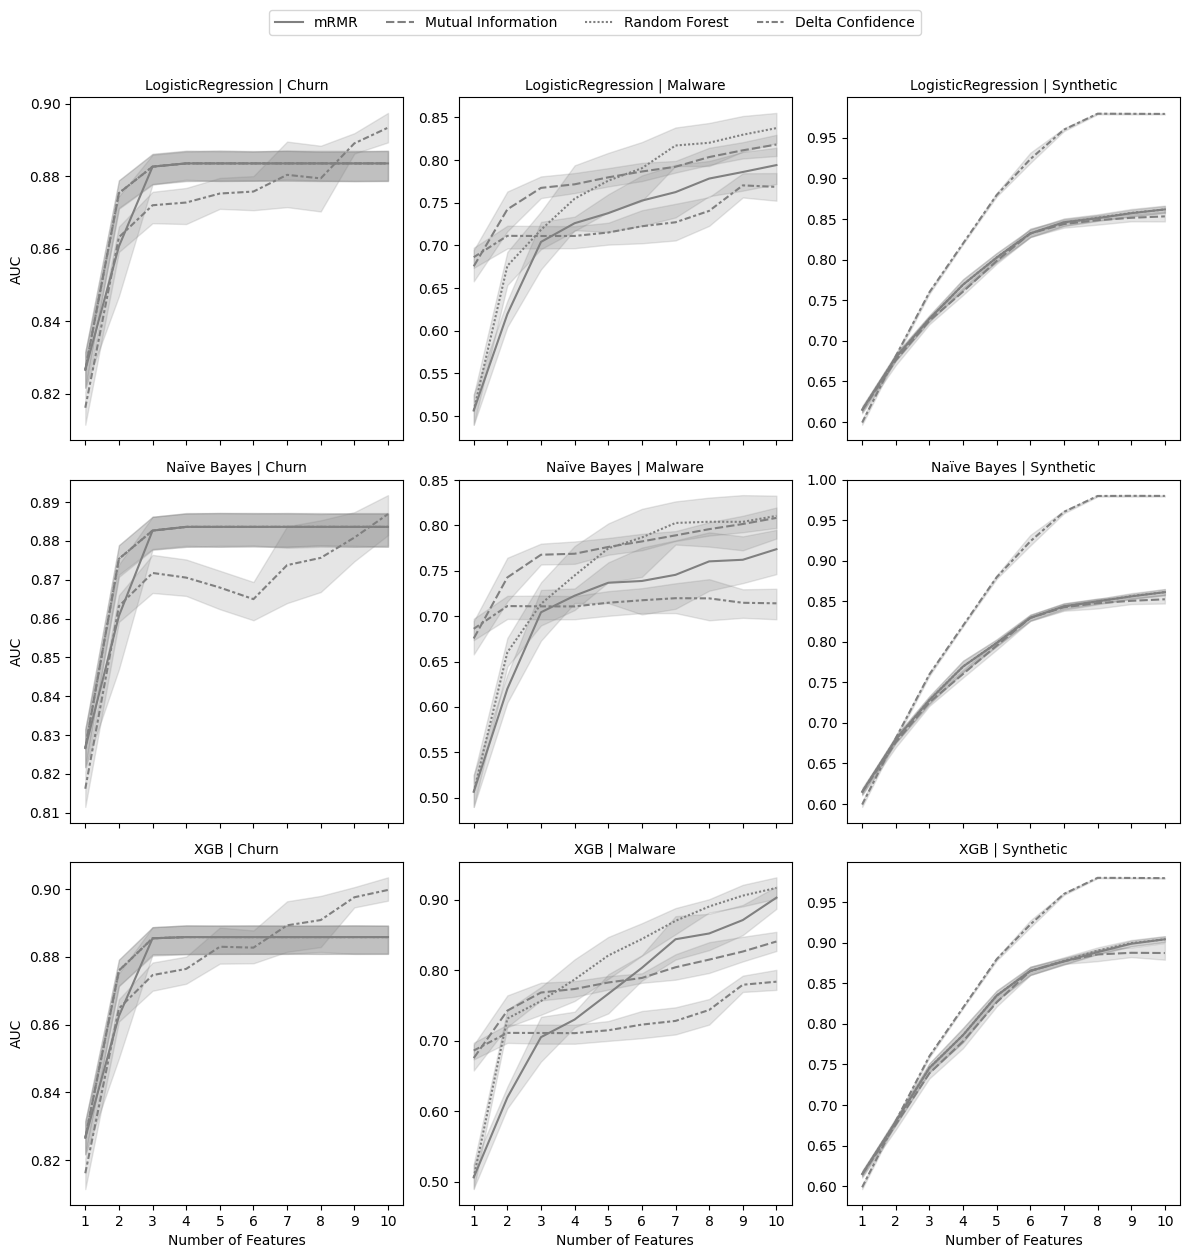

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

metric_col = 'roc_auc_score'
dataset_col = 'fetch_data.class_name'
feat_column = 'preprocess.params.selector.class_name' 
model_column = 'model.params.model'
n_features_column = 'preprocess.params.selector.params.n_features'

mask = data[n_features_column] != 'None'
#mask = mask * (data[model_col] == 'xgboost.XGBClassifier')

df = data[mask].copy(deep=True)

df[n_features_column] = df[n_features_column].astype(int)

metric_col_v = 'AUC'
dataset_col_v = 'Dataset'
feat_col_v = 'Algorithm'
n_features_col_v = 'Number of Features' 

df.rename(columns={
    metric_col: metric_col_v,
    dataset_col: dataset_col_v,
    feat_column: feat_col_v,
    n_features_column: n_features_col_v    
}, inplace=True)

for col in [dataset_col_v, feat_col_v]:
    df[col] = df[col].apply(lambda x: x.split('.')[-1])

df.replace({

    'MRMRFeatSelection': 'mRMR',
    'MutInfoFeatSelection': 'Mutual Information',
    'RFFeatSelection': 'Random Forest',
    'TimeSeriesFeatureSelection': 'Delta Confidence',
    'ChurnDataloader': 'Churn',
    'MalwareDataloader': 'Malware',
    'DataLoader': 'Synthetic',
    'sklearn.linear_model.LogisticRegression': 'LogisticRegression',
    'sklearn.naive_bayes.GaussianNB': 'Naïve Bayes',
    'xgboost.XGBClassifier': 'XGB',
    
    
}, inplace=True)

grey_palette = sns.color_palette(['grey'] * df[feat_col_v].nunique())  # Adjust the number of grey tones based on the unique values in your hue column

# Define line styles for different categories in your hue column
line_styles = {
    #'mRMR': 'solid',
    'Mutual Information': 'dashed',
    'Random Forest': 'dashdot',
    'Delta Confidence': 'dotted'
}

g = sns.FacetGrid(df, row=model_column, col=dataset_col_v, sharey=False, height=4, sharex=True, despine=False)
g.map_dataframe(sns.lineplot, x=n_features_col_v, y=metric_col_v, hue=feat_col_v, palette=grey_palette, style=feat_col_v)

# Customizing the titles
# Here we're using only '{col_name}' to display just the value of the column variable
g.set_titles("{row_name} | {col_name}")

# Customizing tick labels
for ax in g.axes.flat:
    ax.set_xticks([i + 1 for i in range(10)])                    # Set x-tick positions
    ax.set_xticklabels([str(i + 1) for i in range(10)])  # Custom x-tick labels
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

handles, labels = g.axes.flat[0].get_legend_handles_labels()

# Remove any duplicate labels/handles
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Draw the unique legend
g.fig.legend(handles=unique_handles, loc='upper center', labels=unique_labels, bbox_to_anchor=(0.5, 1.05), ncol=len(unique_labels))

# Optionally, adjust the figure to make room for the legend if needed
g.fig.subplots_adjust(top=0.9)

plt.tight_layout()

for extension in ['png', 'pdf']:
    plt.savefig(f'feature_selection.{extension}', dpi=300, bbox_inches='tight', pad_inches=0.25)
plt.show()

In [9]:
data['preprocess.params.selector.class_name'].value_counts()

src.preprocess.selection.mrmr.MRMRFeatSelection                    495
src.preprocess.selection.mutual_info.MutInfoFeatSelection          495
src.preprocess.selection.random_forest.RFFeatSelection             495
src.preprocess.selection.ts_features.TimeSeriesFeatureSelection    495
Name: preprocess.params.selector.class_name, dtype: int64

## Benchmark Analysis

In [5]:
data = get_data(name='sim', query='bench%', n_runs=9999)
data

bench%
Config creation successful.


,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,constants.event_column.placeholder,constants.event_column.value,constants.id_column.placeholder,constants.id_column.value,constants.target_column.placeholder,...,fetch_data.params.configuration.h-i.class,fetch_data.params.configuration.h-i.selection,fetch_data.params.configuration.i-j.class,fetch_data.params.configuration.i-j.selection,fetch_data.params.event_column,fetch_data.params.id_column,fetch_data.params.n_samples,fetch_data.params.separator,fetch_data.params.sequence_elements,fetch_data.params.time_column
0,0.8364,0.8575,0.7597,0.9841,0.8871,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.8444,0.8624,0.7727,0.9757,0.8881,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.8435,0.8621,0.7706,0.9782,0.8882,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.8322,0.8528,0.7595,0.9724,0.8777,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.8423,0.8611,0.7691,0.9782,0.8914,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.8314,0.8521,0.7588,0.9715,0.8883,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.8381,0.8505,0.7898,0.9213,0.9053,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.8414,0.8529,0.7952,0.9197,0.9064,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.8536,0.8641,0.8059,0.9314,0.9083,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.8285,0.8373,0.7962,0.8828,0.8973,product_action,product_action,session_id,session_id,label,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
metric_cols = ['roc_auc_score', 'f1_score']
dataset_col = 'fetch_data.class_name'
feat_column = 'preprocess.params.extractor.class_name' 
model_column = 'model.params.model'
preprocess_column = 'preprocess.params.extractor.class_name'

In [15]:
mask = data['train_test_split.params.random_state'] != '5'
data[mask].groupby([dataset_col, preprocess_column])[metric_cols].mean()

roc_auc_score  \
fetch_data.class_name                    preprocess.params.extractor.class_name                              
src.fetch_data.churn.ChurnDataloader     src.preprocess.extraction.onehot.OneHotEncoder             0.8867   
                                         src.preprocess.extraction.ts_features.SPMFeatur...         0.9055   
src.fetch_data.malware.MalwareDataloader src.preprocess.extraction.onehot.OneHotEncoder             0.9755   
                                         src.preprocess.extraction.ts_features.SPMFeatur...         0.9769   
src.fetch_data.synthetic.DataLoader      src.preprocess.extraction.onehot.OneHotEncoder             0.9069   
                                         src.preprocess.extraction.ts_features.SPMFeatur...         0.9794   

                                                                                             f1_score  
fetch_data.class_name                    preprocess.params.extractor.class_name                        
src.fetch_data.churn.ChurnDataloader     src.preprocess.extraction.onehot.OneHotEncoder        0.8581  
                                         src.preprocess.extraction.ts_features.SPMFeatur...    0.8533  
src.fetch_data.malware.MalwareDataloader src.preprocess.extraction.onehot.OneHotEncoder        0.9230  
                                         src.preprocess.extraction.ts_features.SPMFeatur...    0.9320  
src.fetch_data.synthetic.DataLoader      src.preprocess.extraction.onehot.OneHotEncoder        0.8045  
                                         src.preprocess.extraction.ts_features.SPMFeatur...    0.9044

In [16]:
data[mask].groupby([dataset_col, preprocess_column])[metric_cols].std()

roc_auc_score  \
fetch_data.class_name                    preprocess.params.extractor.class_name                              
src.fetch_data.churn.ChurnDataloader     src.preprocess.extraction.onehot.OneHotEncoder             0.0052   
                                         src.preprocess.extraction.ts_features.SPMFeatur...         0.0056   
src.fetch_data.malware.MalwareDataloader src.preprocess.extraction.onehot.OneHotEncoder             0.0098   
                                         src.preprocess.extraction.ts_features.SPMFeatur...         0.0053   
src.fetch_data.synthetic.DataLoader      src.preprocess.extraction.onehot.OneHotEncoder             0.0045   
                                         src.preprocess.extraction.ts_features.SPMFeatur...         0.0017   

                                                                                             f1_score  
fetch_data.class_name                    preprocess.params.extractor.class_name                        
src.fetch_data.churn.ChurnDataloader     src.preprocess.extraction.onehot.OneHotEncoder        0.0052  
                                         src.preprocess.extraction.ts_features.SPMFeatur...    0.0114  
src.fetch_data.malware.MalwareDataloader src.preprocess.extraction.onehot.OneHotEncoder        0.0192  
                                         src.preprocess.extraction.ts_features.SPMFeatur...    0.0180  
src.fetch_data.synthetic.DataLoader      src.preprocess.extraction.onehot.OneHotEncoder        0.0063  
                                         src.preprocess.extraction.ts_features.SPMFeatur...    0.0063

## Old

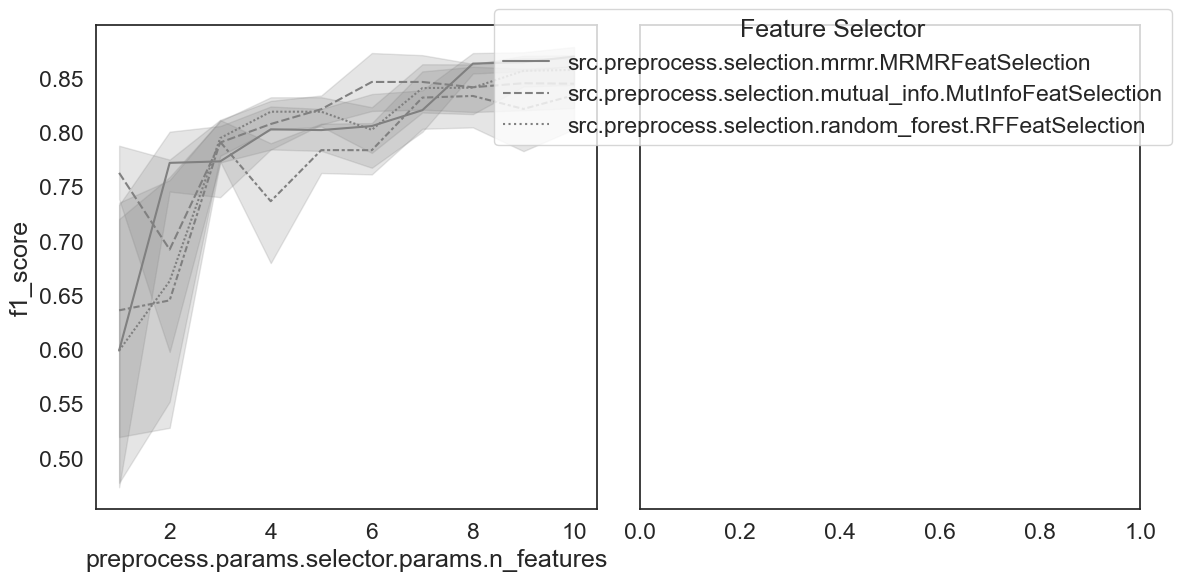

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

df = data[mask].copy(deep=True)

metric_column = 'f1_score'
feat_column = 'preprocess.params.selector.class_name' 
model_column = 'model.params.model'
n_features_column = 'preprocess.params.selector.params.n_features'

df[n_features_column] = df[n_features_column].astype(int)

# Create two subplots and unpack the output array immediately
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.lineplot(data=df, x=n_features_column, y=metric_column, style=feat_column, color='grey', ax=axes[0], legend=None)

# Manually add a joint legend
# Since both subplots use the same 'style' parameter, we need to manually construct the legend
# Let's assume the two selectors are represented as different line styles in the plot
lines_styles = ['-', '--', ':']  # Example line styles for 'Selector A' and 'Selector B'
labels = df['preprocess.params.selector.class_name'].unique()  # Assuming these are 'Selector A' and 'Selector B'
colors = ['grey']  # Assuming all lines are grey; if they have different colors, adjust accordingly

# Create custom handles for the legend
handles = [plt.Line2D([], [], color=colors[0], linestyle=style, label=label)
           for style, label in zip(lines_styles, labels)]

# Add the legend to the figure
f.legend(handles=handles, title='Feature Selector', loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


In [6]:
def analysis_clf(df: pd.DataFrame):
    
    dfc = df.copy(deep=True)
    
    sparsity_column = 'sparsity'
    dfc.rename({'fetch_data.params.time_series_positive.params.sequence_generator.params.sequence_weights.a_c': 'sparsity'}, inplace=True, axis=1)
    metric_columns = ['accuracy_score', 'f1_score']
    
    
    print(dfc.groupby(sparsity_column)[metric_columns].agg(['mean', 'std']))

analysis_clf(df=data)

         accuracy_score           f1_score          
                   mean       std     mean       std
sparsity                                            
0.1                0.83  9.64e-03     0.83  1.13e-02
0.2                0.84  7.91e-05     0.84  8.03e-04
0.3                0.84  1.90e-03     0.85  4.58e-04
0.4                0.86  2.06e-03     0.85  4.40e-03
0.5                0.85  2.34e-02     0.85  2.30e-02
0.6                0.85  2.71e-02     0.85  2.71e-02
0.7                0.86  2.90e-02     0.86  2.88e-02
0.8                0.88  3.23e-02     0.88  3.20e-02
0.9                0.89  3.98e-02     0.89  3.70e-02
1                  0.93  4.80e-02     0.94  4.72e-02


In [7]:
pos_col = 'fetch_data.params.time_series_positive.params.sequence_generator.params.sequence_weights.a_c'
neg_col = 'fetch_data.params.time_series_negative.params.sequence_generator.params.sequence_weights.a_c'

noise = 'noise'
sparsity = 'sparsity'
random_seed = 'fetch_data.params.static_dataset.params.random_seed'

metric = 'f1_score'

In [34]:
data[pos_col].max()

'1.0'

In [44]:
data.filter(like='random')

,fetch_data.params.static_dataset.params.random_seed,preprocess.params.steps.3.params.random_state
0,4,42
1,3,42
2,2,42
3,1,42
4,0,42
...,...,...
0,4,42
1,3,42
2,2,42
3,1,42


In [8]:
for col in [noise, sparsity]:
    data[col] = data[col].astype(float)

In [39]:
df = data[[noise, sparsity, metric]]
df.groupby([noise, sparsity]).size()[df.groupby([noise, sparsity]).size() != 5]

noise  sparsity
0.0    0.9         3
0.1    1.0         4
0.4    1.0         4
dtype: int64

In [10]:
from scipy.stats import ttest_1samp

for noise_score in data[noise].unique():
    for sparsity_score in data[sparsity].unique():
        
        mask = (data[noise] == noise_score) * (data[sparsity] == sparsity_score)
        df_sub = data[mask]
        
        test_result = ttest_1samp(a=df_sub[metric], popmean=0.8377, alternative='greater')
        
        p_val = test_result.pvalue
        
        if test_result.pvalue <= 0.1:
            star = "+"
            
            if p_val < 0.05:
                star = "*"
                
            if p_val < 0.01:
                star = "**"
                
            if p_val < 0.001:
                star = "***"
                
            print(noise_score, sparsity_score, star, df_sub[metric].mean())

0.0 0.5 *** 1.0
0.0 0.6 *** 0.9190480876651869
0.0 0.7 *** 0.8839339655667974
0.1 0.5 *** 0.902465317169999
0.1 0.6 *** 0.8761632542783904
0.1 0.7 * 0.8512999246204128
0.2 0.5 *** 0.8648588611705748
0.2 0.6 + 0.8513590490668017
0.3 0.5 ** 0.8565887445887446


In [50]:
class Outlier(BaseModel):
    
    noise: float
    sparsity: float
    random_seed: int

In [91]:
def round_numbers_to_2_decimals(input_string):
    def round_match(match):
        return '{:.2f}'.format(float(match.group(0)))

    pattern = r'\d+\.\d+'
    result = re.sub(pattern, round_match, input_string)

    return result

def combine_strings(str1, str2):
    words1 = str1.split()
    words2 = str2.split()
    
    combined = f"{round(float(words1[0]), 1)} " + ' '.join(f'{w1}±{w2}' for w1, w2 in zip(words1[1:-1], words2[1:-1])) + f" {words1[-1]}"
    combined = combined.replace('&±&', '&')

    return combined

In [95]:
pd.pivot_table(data=df, index=[noise], columns=[sparsity], values=[metric], aggfunc={metric: ['mean', 'std']})

f1_score                                                          \
             mean                                             std           
sparsity      0.5     0.6     0.7     0.8     0.9     1.0     0.5     0.6   
noise                                                                       
0.0        1.0000  0.9190  0.8839  0.8417  0.8307  0.8377  0.0000  0.0018   
0.1        0.9025  0.8762  0.8513  0.8384  0.8325  0.8366  0.0031  0.0060   
0.2        0.8649  0.8514  0.8345  0.8291  0.8424  0.8350  0.0047  0.0147   
0.3        0.8566  0.8333  0.8127  0.8442  0.8375  0.8326  0.0090  0.0080   
0.4        0.8352  0.8263  0.8370  0.8264  0.8351  0.8381  0.0032  0.0103   
0.5        0.8341  0.8260  0.8355  0.8370  0.8342  0.8305  0.0118  0.0143   
0.6        0.8400  0.8204  0.8336  0.8342  0.8362  0.8382  0.0179  0.0296   
0.7        0.8369  0.8277  0.8407  0.8338  0.8402  0.8287  0.0083  0.0123   
0.8        0.8382  0.8362  0.8453  0.8333  0.8315  0.8341  0.0113  0.0187   
0.9        0.8370  0.8427  0.8321  0.8360  0.8278  0.8306  0.0085  0.0213   
1.0        0.8393  0.8333  0.8336  0.8374  0.8329  0.8384  0.0137  0.0003   

                                          
                                          
sparsity     0.7     0.8     0.9     1.0  
noise                                     
0.0       0.0003  0.0122  0.0003  0.0101  
0.1       0.0099  0.0129  0.0229  0.0069  
0.2       0.0069  0.0025  0.0296  0.0040  
0.3       0.0046  0.0256  0.0183  0.0013  
0.4       0.0003  0.0058  0.0079  0.0099  
0.5       0.0095  0.0085  0.0023  0.0059  
0.6       0.0075  0.0024  0.0182  0.0112  
0.7       0.0169  0.0014  0.0158  0.0100  
0.8       0.0272  0.0002  0.0038  0.0021  
0.9       0.0024  0.0063  0.0119  0.0056  
1.0       0.0009  0.0096  0.0005  0.0117

In [92]:
latex_str_mean = pd.pivot_table(data=df, index=[noise], columns=[sparsity], values=[metric], aggfunc={metric: ["mean"]}).to_latex()
latex_str_std = pd.pivot_table(data=df, index=[noise], columns=[sparsity], values=[metric], aggfunc={metric: ['std']}).to_latex()

latex_str_mean = round_numbers_to_2_decimals(latex_str_mean)
latex_str_std = round_numbers_to_2_decimals(latex_str_std)

print(latex_str_mean)

latex_str_mean_rows = latex_str_mean.split('\n')
latex_str_std_rows = latex_str_std.split('\n')

result = []

for latex_str_mean_row, latex_str_std_row in zip(latex_str_mean_rows, latex_str_std_rows):
    
    if len(latex_str_mean_row) == 0:
        continue
    
    if latex_str_mean_row[0].isdigit():
        
        new_row = combine_strings(latex_str_mean_row, latex_str_std_row)
        result.append(new_row)
        continue
        
    result.append(latex_str_mean_row)
    
print('\n'.join(result))

\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{6}{r}{f1_score} \\
 & \multicolumn{6}{r}{mean} \\
sparsity & 0.50 & 0.60 & 0.70 & 0.80 & 0.90 & 1.00 \\
noise &  &  &  &  &  &  \\
\midrule
0.00 & 1.00 & 0.92 & 0.88 & 0.84 & 0.83 & 0.84 \\
0.10 & 0.90 & 0.88 & 0.85 & 0.84 & 0.83 & 0.84 \\
0.20 & 0.86 & 0.85 & 0.83 & 0.83 & 0.84 & 0.83 \\
0.30 & 0.86 & 0.83 & 0.81 & 0.84 & 0.84 & 0.83 \\
0.40 & 0.84 & 0.83 & 0.84 & 0.83 & 0.84 & 0.84 \\
0.50 & 0.83 & 0.83 & 0.84 & 0.84 & 0.83 & 0.83 \\
0.60 & 0.84 & 0.82 & 0.83 & 0.83 & 0.84 & 0.84 \\
0.70 & 0.84 & 0.83 & 0.84 & 0.83 & 0.84 & 0.83 \\
0.80 & 0.84 & 0.84 & 0.85 & 0.83 & 0.83 & 0.83 \\
0.90 & 0.84 & 0.84 & 0.83 & 0.84 & 0.83 & 0.83 \\
1.00 & 0.84 & 0.83 & 0.83 & 0.84 & 0.83 & 0.84 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{6}{r}{f1_score} \\
 & \multicolumn{6}{r}{mean} \\
sparsity & 0.50 & 0.60 & 0.70 & 0.80 & 0.90 & 1.00 \\
noise &  &  &  &  &  &  \\
\midrule
0.0 & 1.00±0.00 & 0.92±0.00 & 0.88±0.00 & 0

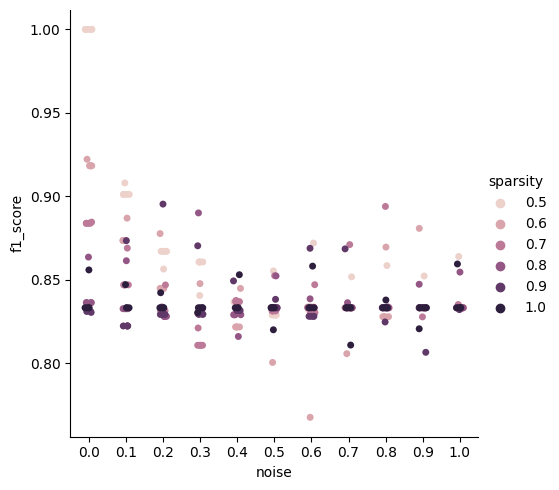

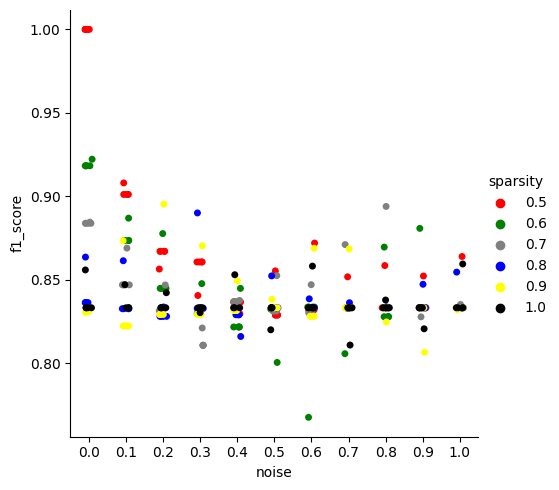

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data=df, x=noise, y=metric, hue=sparsity)
plt.show()

sns.catplot(data=df, x=noise, y=metric, hue=sparsity, palette=sns.color_palette(['red', 'green', 'grey', 'blue', 'yellow', 'black']))
plt.show()

In [ ]:
outliers = [
    Outlier()
]

### Runtime Analysis

In [97]:
data = get_data(name='runtime', query='runtime', n_runs=99)
data

,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,evaluation.class_name,evaluation.params.metrics,evaluation.params.metrics_proba,export.class_name,export.params.experiment_name,...,preprocess.params.steps.3.params.random_state,preprocess.params.steps.3.params.split_col,preprocess.params.steps.3.params.split_type,preprocess.params.steps.3.params.target_name,preprocess.params.steps.3.params.test_size,preprocess.params.steps.4.class_name,preprocess.params.steps.4.params.columns,end_time,run_id,artifact_uri
0,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699115825573,c0bb3673e44c4a79a23cf336bb3be283,file:\c:\users\algrote\desktop\process_analyse...
1,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699115306972,ee4c6a081a80412ab84d4eca0e3000bb,file:\c:\users\algrote\desktop\process_analyse...
2,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699114853481,3310042fa92744f19bd3d9e770a256e0,file:\c:\users\algrote\desktop\process_analyse...
3,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699114495898,fbd8b7806c1c4f768ae46548c74ec9d2,file:\c:\users\algrote\desktop\process_analyse...
4,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699114255039,4e38fb3294754ddf853ffb4cdbd61e90,file:\c:\users\algrote\desktop\process_analyse...
5,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699114092433,ff2b14af8c0743339783a5cd42b006de,file:\c:\users\algrote\desktop\process_analyse...
6,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699114008999,a9475dc4ce154dc394e9352ce521d8b1,file:\c:\users\algrote\desktop\process_analyse...
7,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699113950808,7c017354d52d4128a01b4e6794b8c197,file:\c:\users\algrote\desktop\process_analyse...
8,0.9075,0.9121,0.8864,0.9393,0.9588,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699113908820,cef3fad7ccc9492eba0b9af913fac6e8,file:\c:\use

<Figure size 640x480 with 0 Axes>

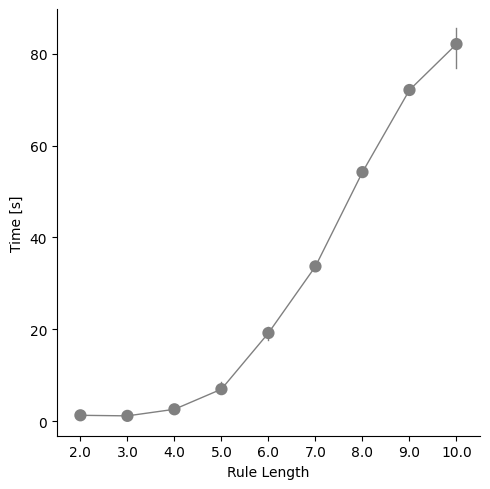

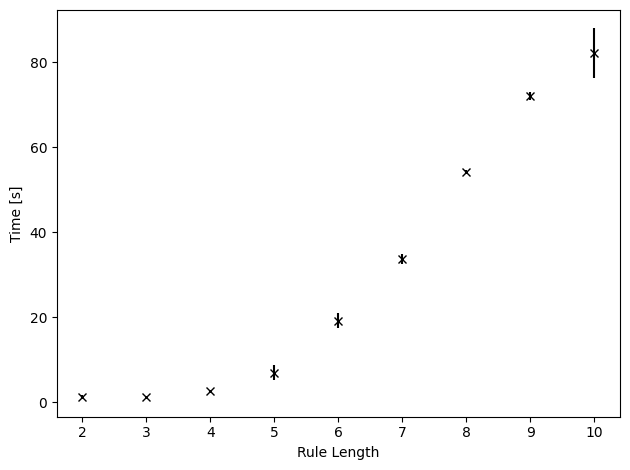

In [145]:
def analyse_mining_time(df: pd.DataFrame):
    
    import yaml
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    
    col_rule = 'rule_length'
    col_time = 'time'
    
    result = pd.DataFrame(columns=[col_rule, col_time])
    
    for idx, row in df.iterrows():
        
        uri = row['artifact_uri'][6:]
        rule_length = row['preprocess.params.steps.1.params.prefixspan_config.params.itertool_threshold']
        
        with open(Path(uri) / 'time.yaml') as file:
            times = yaml.safe_load(file)['rule_mining']
            
            # outlier
            if rule_length == '2':
                times.pop(0)
            tmp = pd.DataFrame({col_time: times, col_rule: rule_length})
            result = pd.concat([result, tmp])
    
    result[col_rule] = result[col_rule].astype(float)
            
    df_agg = result.groupby(col_rule).agg(['mean', 'std']).reset_index()
    df_agg.columns = [col_rule, 'mean', 'std']
    
    plt.figure()
    
    g = sns.catplot(data=result, x=col_rule, y=col_time, kind='point', color='grey')
    
    ax = g.facet_axis(0, 0)
    
    for line in ax.lines:
        line.set_linewidth(1)
        
    # Create a scatter plot to control edge color
    #scatter = ax.scatter(df_agg[col_rule], df_agg['mean'], marker='o', edgecolors='red', facecolors='none', s=100)

    
    plt.xlabel('Rule Length')
    plt.ylabel('Time [s]')
    plt.tight_layout()
    plt.savefig('runtime_catplot.pdf', dpi=300)
    plt.show()
    
    plt.figure()
    plt.errorbar(
        df_agg[col_rule].values, 
        df_agg['mean'].values, 
        df_agg['std'].values, 
        linestyle='None', 
        marker='x',
        color='black',
        ecolor='black'
    )
    plt.xlabel('Rule Length')
    plt.ylabel('Time [s]')
    plt.tight_layout()
    plt.savefig('runtime.pdf', dpi=300)
    plt.show()
    
analyse_mining_time(df=data)

### Other Debugging

In [ ]:
from src.preprocess.ts_feature_selection import RuleClassifier

clf = RuleClassifier(rule=['a', 'c'])

sequences=[
    ['a', 'b', 'c'],
    ['a', 'c'],
    ['a', 'a', 'c'],
    ['a', 'b', 'b', 'c'],
    ['b', 'a', 'd', 'c']
]

for seq in sequences:
    print(clf.apply_rule(seq), '\t', seq)